**file name**: `discrete_anomaly_detection.py` or `discrete_anomaly_detection.ipynb`

Save this work in your `anomaly-detection-exercises` repo. Then add, commit, and push your changes.

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

# Discrete Data + Probability
- Use basic probability to identify anomalous request methods. 
    - You will want to make sure the text is *normalized* in order to reduce the noise.

___
### Wrangle Data

#### Acquire:

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head(2)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [5]:
# begin cleaning up the timestamp by removing the brackets and extraneous tail

df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [6]:
df.head(2)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


In [7]:
# replace the first colon in the timestamp before year 
# to accomodate for pandas datetime
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
# reset index to time
df = df.set_index('timestamp')

In [8]:
df.head(2)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


In [9]:
# clean up strings in columns with extra quotes
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)
df['request_method'] = df.request_method.str.replace(r'HTTP/1.1+', '', regex=True)


df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales,200,511963,NaN,python-requests/2.21.0


In [10]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [11]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Detecting Anomalies in Discrete Variables

### Finding anomalies in already existing data:

In [12]:
# get the counts of ips in the dataset
req_df = df.request_method.value_counts(dropna=False).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'req_count'})

In [13]:
# get the probability of that ip in the dataset
req_df2 = (df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'req_proba'})
# merge/join these together
req_df = req_df.merge(req_df2)

In [14]:
req_df.head(2)

,request_method,req_count,req_proba
0,GET /api/v1/sales,12403,0.887323
1,GET /api/v1/items,1065,0.076191


In [15]:
req_df.shape

(22, 3)

In [16]:
req_df[req_df.req_proba < 0.01]

,request_method,req_count,req_proba
3,GET /,107,0.007655
4,GET /documentation,100,0.007154
5,GET /favicon.ico,26,0.001860
6,GET /api/v1//api/v1/items,11,0.000787
7,GET /api/v1/items/api/v1/items,7,0.000501
8,GET /api/v1/items/next_page,5,0.000358
9,GET /api/v1/,4,0.000286
10,GET /api/v1/itemsitems,3,0.000215
11,GET /api/v1/sales/,3,0.000215
12,GET /api/v1/sales/,3,0.000215


In [17]:
(req_df[req_df.req_proba < 0.01]).shape

(19, 3)

22
                          request_method  req_count  req_proba
12                   GET /api/v1/sales/           3   0.000215
13                    GET /api/v1/store           3   0.000215
14                     GET /api/v1items           2   0.000143
15                  GET /api/V1/HiZach!           1   0.000072
16                          GET /api/v1           1   0.000072
17             GET /api/v1/items&page=0           1   0.000072
18                    GET /api/v1/items/          1   0.000072
19        GET /api/v1/I_DIDNT_DO_IT!!!!           1   0.000072
20              GET /api/v1/helloclass!           1   0.000072
21  GET /api/v1//api/v1/items/next_page           1   0.000072


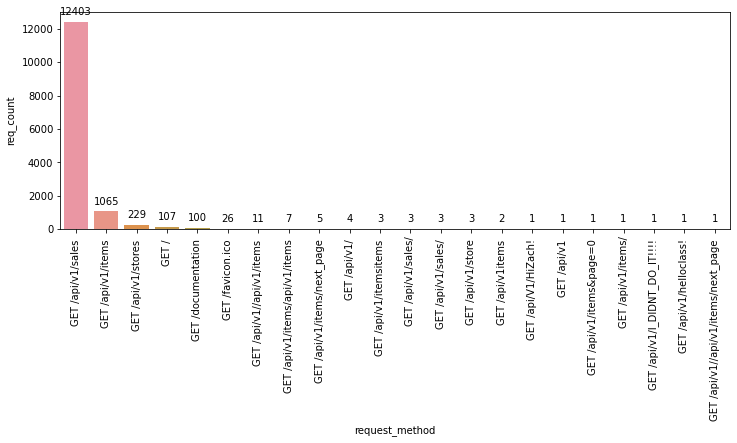

In [18]:
print(len(req_df))

print(req_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=req_df, x = 'request_method', y = 'req_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
plt.xticks(rotation='vertical')
plt.show()

In [22]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

In [24]:
req_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'req_proba'})

In [25]:
df = df.reset_index().merge(req_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.req_proba.value_counts()

0.887577    12403
0.076213     1065
0.016388      229
0.007657      107
0.007156      100
0.001861       26
0.000787       11
0.000215        9
0.000501        7
0.000072        6
0.000358        5
0.000286        4
0.000000        4
0.000143        2
Name: req_proba, dtype: int64

In [27]:
req_probs = train.groupby('request_method').size().div(len(df))

status_given_req = pd.DataFrame(train.groupby(['request_method', 'status']).\
                               size().div(len(train)).\
                               div(req_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_req'})
                              )

In [28]:
status_given_req

,request_method,status,proba_status_given_req
0,GET /,200,1.000286
1,GET /api/V1/HiZach!,200,1.000286
2,GET /api/v1,200,1.000286
3,GET /api/v1/,200,1.000286
4,GET /api/v1//api/v1/items,200,1.000286
5,GET /api/v1//api/v1/items/next_page,200,1.000286
6,GET /api/v1/I_DIDNT_DO_IT!!!!,200,1.000286
7,GET /api/v1/helloclass!,200,1.000286
8,GET /api/v1/items,200,0.996529
9,GET /api/v1/items,499,0.003757


In [30]:
req_status_count = pd.DataFrame(train.groupby(['request_method', 'status'])['ip'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'req_status_count'}))


req_status = status_given_req.merge(req_status_count)

In [31]:
req_status

,request_method,status,proba_status_given_req,req_status_count,ip
0,GET /,200,1.000286,GET /,107
1,GET /,200,1.000286,GET /api/V1/HiZach!,1
2,GET /,200,1.000286,GET /api/v1,1
3,GET /,200,1.000286,GET /api/v1/,4
4,GET /,200,1.000286,GET /api/v1//api/v1/items,11
...,...,...,...,...,...
399,GET /favicon.ico,200,1.000286,GET /favicon.ico,26
400,GET /api/v1/items,499,0.003757,GET /api/v1/items,4
401,GET /api/v1/items,499,0.003757,GET /api/v1/sales,12
402,GET /api/v1/sales,499,0.000968,GET /api/v1/items,4


In [32]:
df = df.reset_index().merge(req_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [33]:
df.head()

,ip_x,request_method,status,size,destination,request_agent,size_mb,req_proba,proba_status_given_req,req_status_count,ip_y
timestamp,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,python-requests/2.21.0,0.488753,0.887577,0.999318,GET /,107.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,python-requests/2.21.0,0.488753,0.887577,0.999318,GET /api/V1/HiZach!,1.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,python-requests/2.21.0,0.488753,0.887577,0.999318,GET /api/v1,1.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,python-requests/2.21.0,0.488753,0.887577,0.999318,GET /api/v1/,4.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,python-requests/2.21.0,0.488753,0.887577,0.999318,GET /api/v1//api/v1/items,11.0


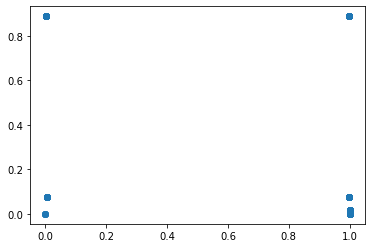

In [34]:
plt.scatter(df.proba_status_given_req, df.req_proba)
plt.show()